## Importing Libraries and Data

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading the data
data = pd.read_excel('online_retail_II.xlsx', sheet_name=1, index_col=False)

## Data Check and Cleaning

In [3]:
# Checking for % of null values
round(100*(data.isnull().sum() / len(data)), 2)

Invoice         0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    24.93
Country         0.00
dtype: float64

In [4]:
# Considering data where customer ID is not null
data = data[~data['Customer ID'].isnull()]

In [5]:
# Checking for null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [18]:
rows_after_drop_dup = len(data.drop_duplicates())
rows = len(data)
print(f"Rows before dropping duplicates = {rows}\n\
Rows after dropping duplicates = {rows_after_drop_dup}\n\
Number of duplicate values = {rows - rows_after_drop_dup}")

Rows before dropping duplicates = 406830
Rows after dropping duplicates = 401605
Number of duplicate values = 5225


In [19]:
data.drop_duplicates(inplace=True)

## RFM Analysis

### Calculating the Recency

In [30]:
# Calulating the Recency
recency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].max()
recency.columns = ['Customer ID', 'Last Purchase Date']
recent_date = recency['Last Purchase Date'].max()
recency['Recency'] = recency['Last Purchase Date'].apply(lambda x: (recent_date - x).days)

In [32]:
recency.head()

,Customer ID,Last Purchase Date,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


### Calculating the Frequency

In [33]:
frequency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].count()
frequency.columns = ['Customer ID', 'Frequency']
frequency.head()

,Customer ID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Calculating the Monetary Value

In [34]:
data['Total'] = data['Quantity'] * data['Price']
monetary = data.groupby('Customer ID', as_index = False)['Total'].sum()
monetary.columns = ['Customer ID', 'Monetary']

In [35]:
monetary.head()

,Customer ID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Caculating the RFM Rank and Score

In [40]:
rf = recency.merge(frequency, on='Customer ID')
rfm = rf.merge(monetary, on='Customer ID')
rfm.head()

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:17:00,325,2,0.00
1,12347.0,2011-12-07 15:52:00,1,182,4310.00
2,12348.0,2011-09-25 13:13:00,74,31,1797.24
3,12349.0,2011-11-21 09:51:00,18,73,1757.55
4,12350.0,2011-02-02 16:01:00,309,17,334.40


In [43]:
rfm['R Rank'] = rfm.Recency.rank(ascending=False)
rfm['F Rank'] = rfm.Frequency.rank(ascending=False)
rfm['M Rank'] = rfm.Monetary.rank(ascending=False)

rfm['R_rank_norm'] = (rfm['R Rank'] / rfm['R Rank'].max())*100
rfm['F_rank_norm'] = (rfm['F Rank'] / rfm['F Rank'].max())*100
rfm['M_rank_norm'] = (rfm['M Rank'] / rfm['M Rank'].max())*100

rfm.drop(['R Rank', 'F Rank', 'M Rank'], axis=1, inplace=True)

rfm.head()

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,2011-01-18 10:17:00,325,2,0.00,3.865741,98.407570,98.959286
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,97.719907,12.000923,7.296432
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,38.182870,58.469882,22.301006
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,72.974537,33.602585,22.895700
4,12350.0,2011-02-02 16:01:00,309,17,334.40,5.578704,75.905839,70.082342


In [45]:
# Calculating RFM Score using Formula

rfm['RFM_Score'] = 0.15*rfm['R_rank_norm'] + 0.28*\
rfm['F_rank_norm'] + 0.57*rfm['M_rank_norm']
rfm['RFM_Score'] *= 0.05
rfm = rfm.round(2)
rfm.head(10)

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,12346.0,2011-01-18 10:17:00,325,2,0.00,3.87,98.41,98.96,4.23
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,97.72,12.00,7.30,1.11
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,38.18,58.47,22.30,1.74
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,72.97,33.60,22.90,1.67
4,12350.0,2011-02-02 16:01:00,309,17,334.40,5.58,75.91,70.08,3.10
5,12352.0,2011-11-03 14:37:00,35,95,1545.41,57.85,26.75,25.77,1.54
6,12353.0,2011-05-19 17:47:00,203,4,89.00,17.01,95.87,96.04,4.21
7,12354.0,2011-04-21 13:11:00,231,58,1079.40,14.16,40.21,34.84,1.66
8,12355.0,2011-05-09 13:49:00,213,13,459.40,15.80,81.62,60.27,2.98
9,12356.0,2011-11-17 08:40:00,22,59,2811.43,68.84,39.74,13.17,1.45


In [49]:
rfm['Customer_Segment'] = np.where(rfm['RFM_Score'] > 4.5, 'Top Customers',\
                                  np.where(rfm['RFM_Score'] > 4, 'High Value Customers',\
                                          np.where(rfm['RFM_Score'] > 3, 'Medium Value Customers',\
                                                  np.where(rfm['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))
rfm[['Customer ID', 'RFM_Score', 'Customer_Segment']].head(20)

,Customer ID,RFM_Score,Customer_Segment
0,12346.0,4.23,High Value Customers
1,12347.0,1.11,Lost Customers
2,12348.0,1.74,Low Value Customers
3,12349.0,1.67,Low Value Customers
4,12350.0,3.10,Medium Value Customers
5,12352.0,1.54,Lost Customers
6,12353.0,4.21,High Value Customers
7,12354.0,1.66,Low Value Customers
8,12355.0,2.98,Low Value Customers
9,12356.0,1.45,Lost Customers


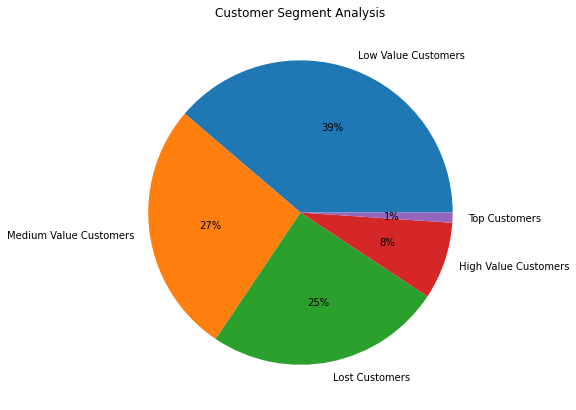

In [58]:
plt.figure(figsize=(10,7))
plt.pie(rfm['Customer_Segment'].value_counts(), labels = rfm['Customer_Segment'].value_counts().index,\
        autopct = '%0.f%%')
plt.title('Customer Segment Analysis')
plt.show()